# Plots for the 2MDM analysis

In [82]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.matplotlib.colormaps.get_cmap('RdYlBu')

#### Create txname/process translator

In [83]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1qq' : r'$p p \to q \bar{q}$',
               'TRV1jj' : r'$p p \to j  \bar{j}$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

#### Get data in pcl format

In [84]:
#Merge with SModelS DataFrame
pclFiles = ['/home/yoxara/2MDM/data/2mdm_results_all/results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900026', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.chi,chi', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.chi,chi', 'extpar.8', 'xsec13TeV(fb).9900032', 'BRs.sd.q,q,W+', 'BRs.sd.c,q,W+', 'BRs.sd.W-,q,q', 'BRs.sd.W-,q,c', 'BRs.sd.W-,ta+,nu', 'BRs.sd.W-,e+,nu', 'BRs.sd.W-,mu+,nu', 'BRs.sd.nu,e-,W+', 'BRs.sd.nu,mu-,W+', 'BRs.sd.nu,ta-,W+', 'BRs.sd.ta+,ta-', 'BRs.sd.q,q,Z', 'BRs.sd.b,b,Z', 'BRs.sd.c,c,Z', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'SMS Decomposition', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'To

#### Set r = 0 for points with no results 

In [85]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [86]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [87]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 500
Total excluded (LHC) = 237
Total allowed = 263



### Get all exclusion curves

In [88]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID']


In [89]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [90]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [91]:
txnames.append(['TRS1', 'TRV1'])

In [92]:
txnames

['TRV1jj', 'TRV1bb', 'TRV1', 'TRV1qq', 'TRV1tt', ['TRS1', 'TRV1']]

In [93]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and row[idc.replace('AnalysisID','TxNames')] == [txID])]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [94]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [95]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-EXOT-2019-03,[TRV1jj],20.260700
1,CMS-EXO-20-004,[TRV1],0.042598
2,ATLAS-EXOT-2019-03,[TRV1jj],19.985020
3,CMS-EXO-20-004,[TRV1],0.162517
4,ATLAS-EXOT-2019-03,[TRV1jj],19.339580
...,...,...,...
973,CMS-EXO-12-059,[TRV1qq],0.012949
974,CMS-EXO-12-059,[TRV1qq],0.012938
975,CMS-EXO-12-059,[TRV1qq],0.012722
976,CMS-EXO-12-059,[TRV1qq],0.012718


In [96]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels

In [97]:
# newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
# excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

In [98]:
colors = sns.color_palette("Dark2",len(excluded['label'].unique()))


In [99]:
colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [100]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

/tmp/ipykernel_22826/3227815988.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu_r')


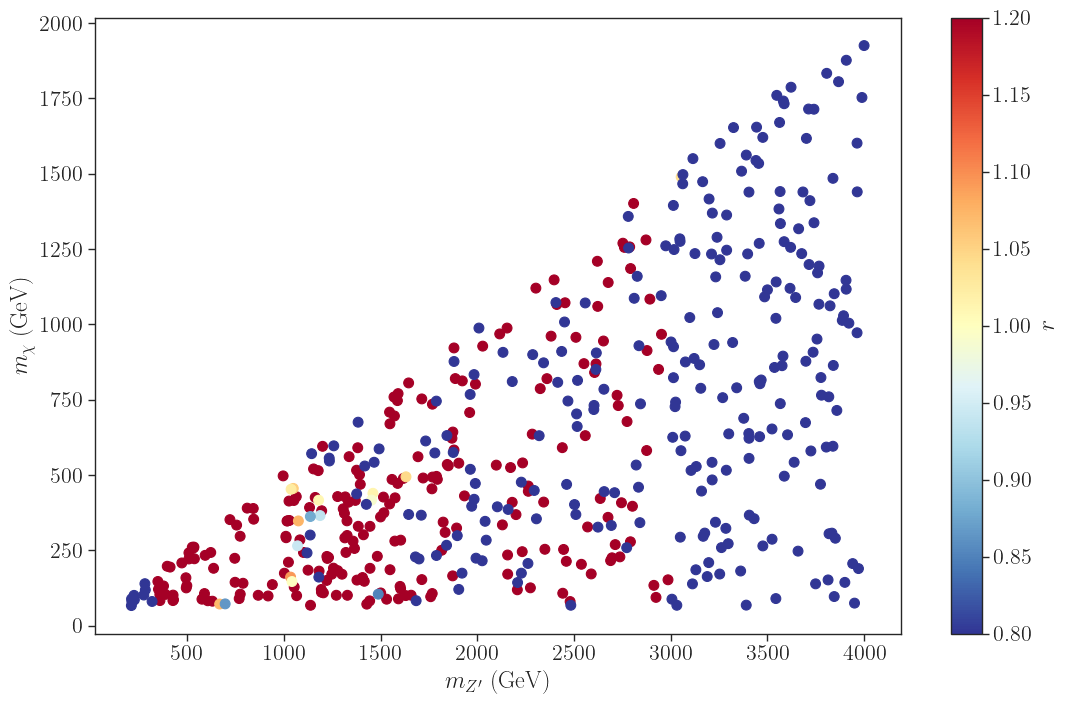

In [101]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))


x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['ExptRes.result0.r']

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
# plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
#          transform = plt.gca().transAxes)

# plt.legend()
plt.show()

In [102]:
dataDF['extpar.1'].unique()

array([1.6])

In [103]:
dataDF['extpar.2'].unique()

array([0.25])

In [104]:
newDF['label'].unique()

array(['ATLAS-EXOT-2019-03 (TRV1jj)', 'CMS-EXO-20-004 (TRV1)',
       'ATLAS-EXOT-2018-48 (TRV1tt)', 'CMS-EXO-20-008 (TRV1bb)',
       'CMS-EXO-16-057 (TRV1bb)', 'ATLAS-EXOT-2013-11 (TRV1qq)',
       'CMS-EXO-12-059 (TRV1qq)'], dtype=object)

In [105]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

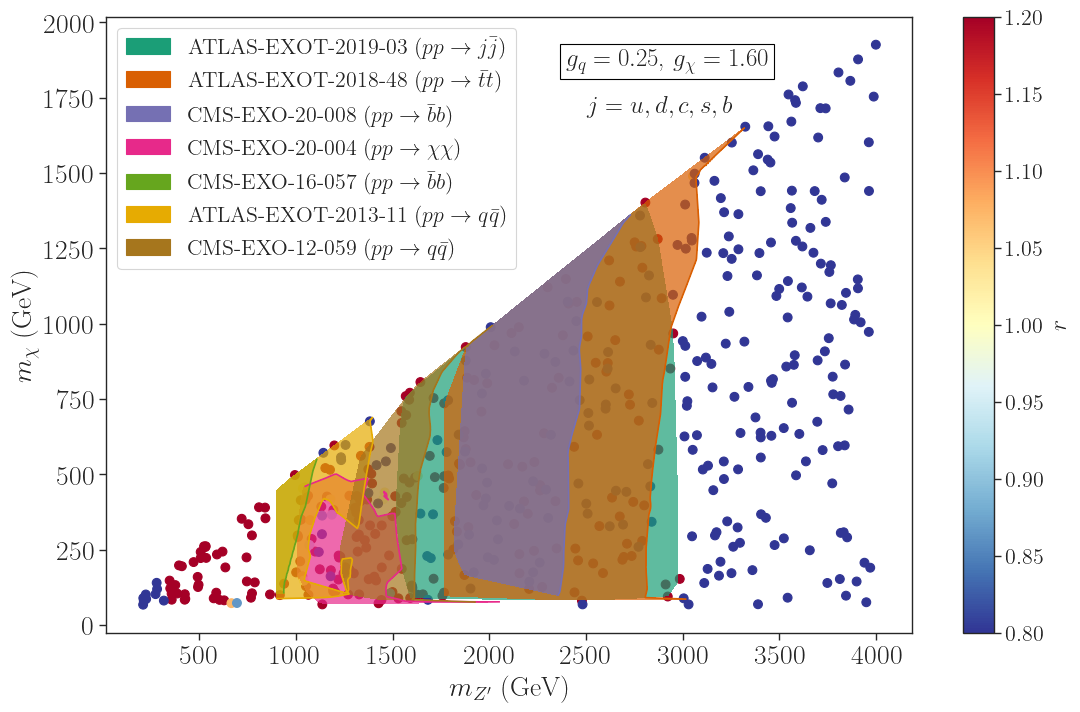

In [106]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(13,8))

gqv = 0.25
gchi = 1.6

x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
c = dataDF['ExptRes.result0.r'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()

sc = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
#     if label != 'CMS-EXO-20-004 (TRV1)': continue
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.7, colors=colorDict[label])
    
    
plt.legend(handles=[legend[0], legend[1], legend[2], legend[3], legend[4], legend[5], legend[6]])
#legend[7]

plt.colorbar(sc, label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=20)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=20)
plt.text(0.57,0.92,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=18,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.text(2500,1700,r'$j = u, d, c, s, b$',fontsize=18)
plt.savefig('exclusions_2mdm.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

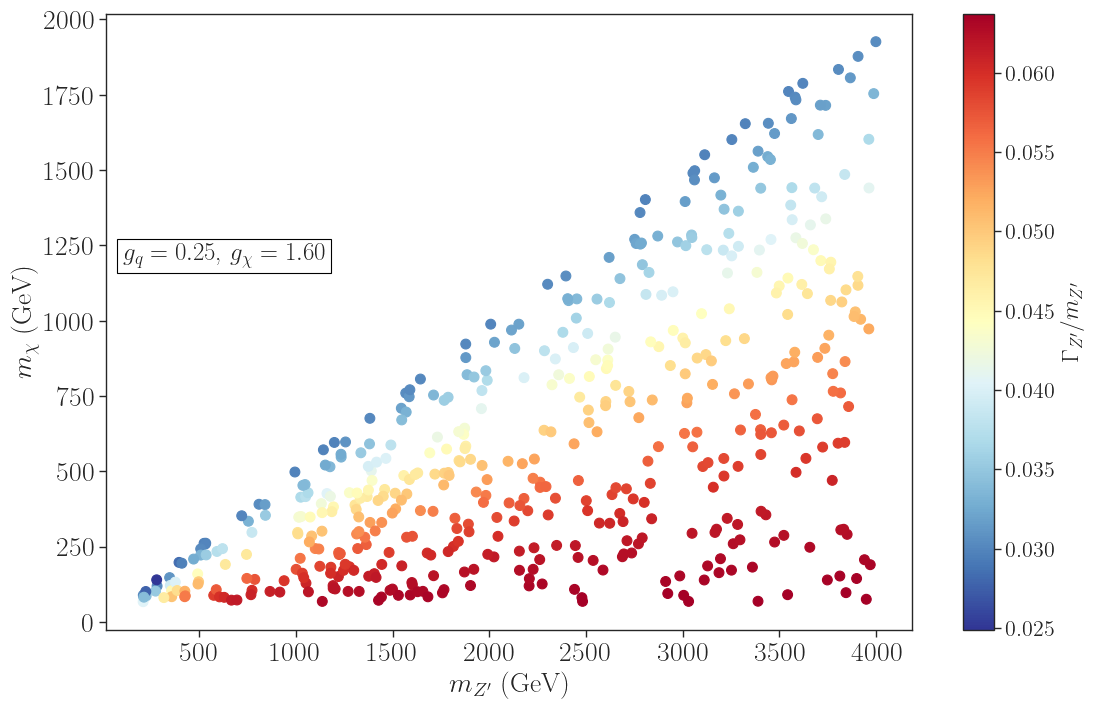

In [107]:
plt.colormaps['RdYlBu_r']
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.25
gchi = 1.6

x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
c = dataDF['width.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()/dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()

plt.scatter(x,y,c=c,s=50,cmap=cm)
plt.colorbar(label=r'$\Gamma_{Z^{\prime}} / m_{Z^{\prime}}$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=20)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=20)
plt.text(0.02,0.6,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=18,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.savefig('ratio_wm_2mdm.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [108]:
# reescale r to match gq = 0.2
def rescale_r(anaID, r, gq, gq_new=0.2):
    """
    Function that receives values for analysis ID, r, and the coupling to quarks and reescales the value of r
    depending on the process (pp -> qq or pp -> dm dm). For analysis involving dijets, the r will reescale as 
    (gq_new/gq)**4, while for analysis involving dm, it will reescale as (gq_new/gq)**2
    :param values: refer to columns 'ExptRes.result.AnalysisID', 'ExptRes.result.r', and 'extpar.2', in this order
    :return: reescaled r for selected gq
    """
    gqv = 0.25
    k_dijets = (gq_new/gq)**4
    k_dm = (gq_new/gq)**2
    k_dm2 = (5.0/1.6)**2
#     k_dm2 = 1
#     k_dm = 1
#     k_dijets = 1
    if gq == gqv:
        if anaID == 'CMS-EXO-20-004':
            return r*k_dm*k_dm2
        else:
            return r*k_dijets
    else: return r
    

In [109]:
newDF['ExptRes.result.r_new'] = newDF.apply(lambda x: rescale_r(anaID=x['ExptRes.result.AnalysisID'],
                                                                r=x['ExptRes.result.r'], gq=x['extpar.2'],
                                                                gq_new=0.15), axis=1)

In [110]:
newDF = newDF.sort_values(by=['ExptRes.result.r_new'],ascending=True)

ValueError: Contour levels must be increasing

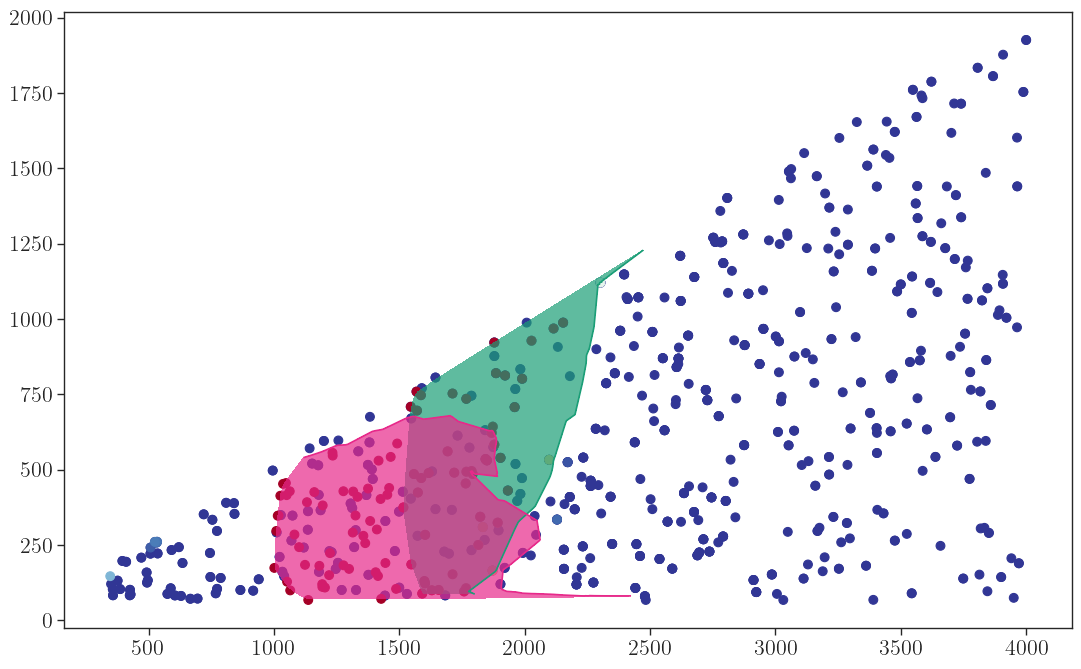

In [111]:
plt.colormaps['RdYlBu_r']
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.25
gchi = 1.6
gqv_new = 0.15
gchi_new = 5.0

x = newDF['mass.9900032'][(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv)]
y = newDF['mass.9000006'][(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv)]
c = newDF['ExptRes.result.r_new'][(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv)]
sr = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
#     if label == 'CMS-EXO-19-012 (TRV1jj)': continue
    if label == 'ATLAS-EXOT-2018-48 (TRV1tt)': continue
    if label == 'CMS-EXO-20-008 (TRV1bb)': continue
 #   if label == 'CMS-PAS-EXO-20-008 (TRV1bb)': continue
#     print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r_new']
    pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.7, colors=colorDict[label])
    
    
plt.legend(handles=[legend[0], legend[1], legend[4]], fontsize=18)


plt.colorbar(sr, label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=20)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=20)
plt.text(0.02,0.7,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv_new, gchi_new),fontsize=18,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)
# plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')

# plt.xlim(990.0, 3100.0)
# plt.ylim(90.0,1500.0)
plt.savefig('exclusions_2mdm_reescaled.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()